In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive/')

# 目的の場所（フォルダ・ディレクトリ）へ移動（各自の環境で適宜修正）
%cd "/content/drive/MyDrive/Colab Notebooks/JKJ1A/"
%ls

---
# 準備

In [ ]:
# モジュールのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
import sys
sys.path.append('src_day1')  # src_day1にあるコードを利用できるようにする

from vgg import VGG
from cifar10 import load_data

### 復習問題（5分）
- 課題2で保存したVGGモデルを`net`として読みこめ
- `load_data()`関数を利用してCIFAR10を読みこめ．これで`trainloader`, `testloader`, `classes`が準備される．`batch_size`は16とせよ
作成したコードやDay 1などのノートブックからコピペしてくれば良い

#### 解答

In [ ]:
from vgg import VGG as Net

PATH = './model/model_cifar10.pth'
net = Net('VGG11')                   # 空のネットワークを準備
net.eval()                           # 評価モードにする
state_dict = torch.load(PATH)        # 保存したパラメタをロード
net.load_state_dict(state_dict)      # ネットワークにパラメタをセット

trainloader, testloader, classes = load_data(16)

---
# 敵対的サンプルの生成

### ロスを悪化させるよう画像を修正する

In [ ]:
# クロスエントロピーロス関数
criterion = nn.CrossEntropyLoss()

In [ ]:
# ミニバッチを一つ取得
itr = iter(trainloader)
images, labels = itr.next()

# ネットワークの出力
outputs = net(images)

# ネットワークの出力のロス（学習済みのモデルなのでとても低い値）
loss = criterion(outputs, labels)
print(f'loss = {loss.item()}')

loss = 1.1399326922401087e-06


In [ ]:
# ロスが悪化するようなに画像の「修正量」`delta`を計算したい

delta = torch.zeros_like(images)    # 画像と同じサイズのゼロテンソルを準備（これが修正量になる）
delta.requires_grad = True          # 勾配を計算したいので

outputs = net(images + delta)       # 修正を加えたものをネットワークに入力（この時点ではdelta=0）

loss = criterion(outputs, labels)   # ロスを計算
correct = (outputs.argmax(dim=-1) == labels).sum()  # 正解数
print(f'loss = {loss.item()}, #correct = {correct.item()}')

net.zero_grad()
loss.backward()                     # 誤差逆伝播（Backpropagation）で勾配を計算
grad = delta.grad                   # deltaの勾配
grad = F.normalize(grad, dim=(1,2,3))  # 勾配のノルムを1になるよう正規化
delta.data += grad                  # deltaを更新

outputs = net(images + delta)       # 勾配に沿って画像を修正してネットワークに入力
loss = criterion(outputs, labels)   # ロスを計算
correct = (outputs.argmax(dim=-1) == labels).sum()  # 正解数
print(f'loss = {loss.item()}, #correct = {correct.item()}') # ロスが悪化している！

loss = 1.1399326922401087e-06, #correct = 16
loss = 8.001028060913086, #correct = 4


## 修正前と修正後の画像を比較

In [ ]:
# 画像を表示するための関数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (10,5))  # 横幅, 縦幅
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 複数の画像を並べて表示する関数
def imshow_list(images): 
    imshow(torchvision.utils.make_grid(images))

### 練習問題１（10分）
上の`imshow_list`を用いて，修正前の画像と修正後の画像を表示せよ（見やすさのため，前4枚の画像`images[:4]`だけ表示すれば良い）．

また，それぞれの画像に対して，予測ラベルを表示せよ

#### 解答


In [ ]:
# 今後の便利のために関数にした（こういう発想は大事）
def cmp_images(net, images, labels, delta, classes, n_show):
    preds1 = net(images).argmax(dim=-1)  # 予測ラベル
    imshow_list(images[:n_show])
    print(' '.join('%5s' % classes[preds1[j]] for j in range(n_show)))

    preds2 = net(images + delta).argmax(dim=-1)  # 予測ラベル
    imshow_list((images + delta)[:n_show])
    print(' '.join('%5s' % classes[preds2[j]] for j in range(n_show)))

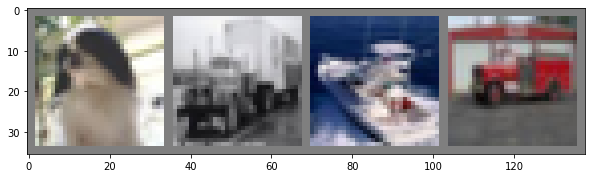

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog truck  ship truck


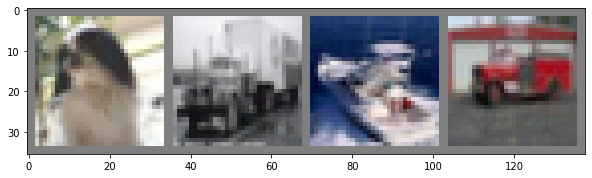

  cat  ship plane   car


In [ ]:
n_show = 4
cmp_images(net, images, labels, delta, classes, n_show)

## Fast Gradient Signed Method (FGSM)

In [ ]:
def fgsm(net, images, labels, epsilon):
    delta = torch.zeros_like(images)        # 画像と同じサイズのゼロテンソルを準備（これが修正量になる）
    delta.requires_grad = True              # 勾配を計算したいので

    outputs = net(images + delta)           # 修正を加えたものをネットワークに入力（この時点ではdelta=0）
    loss = F.cross_entropy(outputs, labels)  # ロスを計算
    loss.backward()                         # 誤差逆伝播（Backpropagation）で勾配を計算

    grad = delta.grad                       # deltaの勾配
    grad = grad.sign()                      # !! 全ての値を正負によって+1or-1にする
    delta.data += grad      
    delta.data = delta.data.clamp(-epsilon, epsilon)  # !! deltaの各要素の値の範囲が[-epsilon, epsilon]になるよう切り落とす
    return delta.detach()

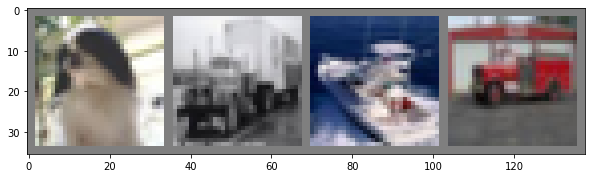

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog truck  ship truck


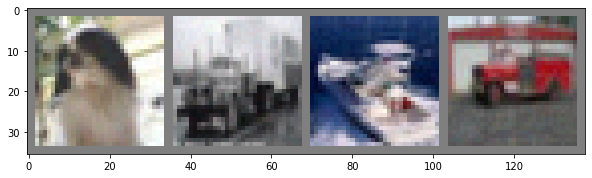

  cat  ship plane   car


In [ ]:
epsilon = 0.03
delta = fgsm(net, images, labels, epsilon)
cmp_images(net, images, labels, delta, classes, 4)  # n_show = 4

---
# 敵対的サンプルの評価

### 練習問題２（10分）
FGSMの攻撃強度`epsilon`は攻撃強度を表す．様々な`epsilon`に対してネットワークの分類精度を計算せよ．

その結果をグラフとしてプロットせよ（横軸が`epsilon`，縦軸が分類精度）．

In [ ]:
# 以下の`epsilon`を横軸にプロットせよ．
epsilons = [0.0, 0.001, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
accs = []

for epsilon in epsilons:
    ##この中を埋める



    accs.append(acc.item())


plt.plot(epsilons, accs)    
plt.xlabel(' epsilon ')
plt.ylabel(' accuracy ')
plt.title(' classification accuracies under FGSM attack ')
plt.show()

#### 解答

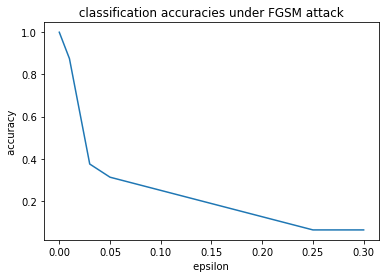

In [ ]:
# 以下の`epsilon`を横軸にプロットせよ．
epsilons = [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accs = []

for epsilon in epsilons:
    delta = fgsm(net, images, labels, epsilon)
    preds = net(images + delta).argmax(dim=-1)
    acc = (preds == labels).sum() / len(labels)
    accs.append(acc.item())

plt.plot(epsilons, accs)    
plt.xlabel(' epsilon ')
plt.ylabel(' accuracy ')
plt.title(' classification accuracies under FGSM attack ')
plt.show()

### 練習問題３（20分）

関数`test_fgsm(net, dataloader, epsilon)`を定義せよ．この関数は
```
acc = test_fgsm(net, trainloader, 0.03)
```
のように使って，FSGMで攻撃された画像全体に対する分類精度を返すようにしたい．

これを設計した上で，練習問題2のように`epsilon`と正解率を軸とするプロットをせよ．訓練データ，テストデータそれぞれの分を重ねて一つのグラフにせよ（2本の折れ線が表示されるイメージ）．

以下のようにplt.show()が登場するまでの分のグラフは勝手に重なる．
```
plt.plot(...)
plt.plot(...)
plt.show()
```

#### 解答

`test_fgsm()`は，Day 1で作った`test()`を微修正するだけで作れる．プロットに関しては以下のようになる．


In [ ]:
net.cuda()  # GPUを使う

# 訓練データでの処理
accs_train = []
for epsilon in epsilons:
    acc = test_fgsm(net, trainloader, epsilon)  # test_fgsm()はGPUを使うように作られているはず
    accs_train.append(acc.item())

# テストデータでの処理
accs_test = []
for epsilon in epsilons:
    acc = test_fgsm(net, testloader, epsilon)
    accs_test.append(acc.item())

plt.plot(epsilons, accs_train, label='training')
plt.plot(epsilons, accs_test, label='test')
plt.legend()
plt.show()  

解答を見て気づいた人もいるかもしれないが，訓練データ・テストデータでほとんど同じ処理が行われている．なので，これも関数化すると後で便利そうである．

# 敵対的サンプルに対する防御

Adversarial Trainingにより，敵対的サンプルに騙されづらいモデルを学習する．ATの考えは単純で，学習中に敵対的サンプルを生成しそれを正しく分類できるようにするというものである．概観は以下のようになる．

```
for data in trainloader():
    images, labels = data

    net.eval()            # <--------- おまじない（忘れないこと！）
    delta = fgsm(...)
    net.train()           # <--------- おまじない（忘れないこと！）

    outputs = net(images + delta)
    loss = ...
```

### 実験課題１（60分）

Adversarial Traningを実装し，`src`ディレクトリに`adversarial_attack.py`と`advtrain_cifar10.py`を作成せよ．次のようにしてATが実行できるようにせよ．

In [ ]:
%%time
!python src/advtrain_cifar10.py --nepochs 30 --batch_size 128 --lr 0.01 --epsilon 0.03 --save_model_name 'model/model_cifar10_fgsm0.03.pth'

実装にあたり以下の点に留意せよ
- `adversarial_attack.py`には`fgsm()`という関数を定義する．
- `advtrain_cifar10.py`で，`from adversarial_attack import fgsm`として読み込む
- `advtrain_cifar10.py`はDay1課題の`train_cifar10.py`を修正する形で作ると良い．

### 実験課題２（60分）

いくつかの異なる`epsilon`のFGSMで訓練したモデルを準備し，その上で練習問題３で作った様なプロットを作成せよ．作成したプロットから，どの様なことが読み取れるだろうか，議論せよ．実装にあたり以下の点に留意せよ

- プロットには`epsilon = 0`の場合も含めよ（ATをしていない場合に相当・Day1で学習したモデルを用いれば良い．`lr`, `nepochs`, `batch_size`などは揃えること）
- ファイル名のエプシロンにあたる部分は0.xxの形式に統一すると後で便利（0, 00, 0.01など）
- 今回のプロットはテストデータでの敵対的サンプルの分類精度だけで良い．その代わり，異なる`epsilon`を用いたATの結果を重ねてプロットせよ．
- `nepochs = 10`, `lr = 0.01`などがおすすめ．

In [ ]:
# プロットに用いる`epsilon`
epsilons = [0.0, 0.001, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

# Adversarial Traningに用いる`epsilon`
epsilons_train = [0.01, 0.02, 0.03]

# プロットは，横軸と縦軸に関しては練習問題3と同様で，4本の折れ線グラフが重ねられていることになる（ATしない場合 + `epsilons_train`に3つ）．

### 実験課題３（10分）

FGSMよりも強力な攻撃方法として，Projected Gradient Descent (PGD)がある．これは単純にFGSMを繰り返し適用するものとほぼ同一であり，次の様に実装される．

In [ ]:
def pgd(model, X, y, epsilon, alpha, n_iter):
    delta = torch.zeros_like(X, requires_grad=True)

    for t in range(n_iter): # ほぼFGSMと同じ, n_iter回繰り返し
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        grad = delta.grad.data 
        delta.data = (delta + alpha*grad.sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()

    return delta.detach()

PGDでは`epsilon`に加え，新たなパラメータとして`alpha`, `n_iter`が加わった．直感的には，「1回あたり`alpha`程度の更新のFGSMを`n_iter`回繰り返し，最終的に`epsilon`程度の変化にする」というものである．

さて，実験課題２でATしたモデルを利用して，実験課題２と同様のプロットを作成せよ．ただし評価の時に用いる攻撃はFGSMではなくPGDを用いよ．その結果を議論せよ．実装にあたり次のことに留意せよ．
- 要は，`test_fgsm()`の代わりに`test_pgf()`を作ってそれで評価せよ，ということである．
- `n_iter=7`程度，`alpha`は，`epsilon/n_iter * 1.2`程度などが良い．

余裕があれば，`epsilon`を固定して`n_iter`を変化させた時の場合も考えてみよ．